# Imports

# Global settings

# Data split load

# Localization

In [2]:
import pytorch_lightning as pl
# your favorite machine learning tracking tool
from pytorch_lightning.loggers import WandbLogger


In [3]:
import numpy as np
import random
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchmetrics.classification import AUROC,AveragePrecision
import torchmetrics
from sklearn.metrics import roc_curve, auc
import os
from sklearn.model_selection import train_test_split
import shutil
from copy import deepcopy
from tqdm import tqdm
from matplotlib import pyplot as plt

In [4]:
class BrainDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.transform_train = transforms.Compose([
                                        transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(5,translate=[0,.1],scale=[.9,1.1]),
                                      transforms.ToTensor(),
                                      transforms.Normalize( mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225])
                                      
                                     ])
        self.transform = transforms.Compose([
            transforms.Resize((256,256)),

            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225])
        ])
        
        self.num_classes = 4
    
    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
                self.train = ImageFolder(self.data_dir+"/train",
                                    transform=self.transform_train,
                                )

                self.val = ImageFolder(self.data_dir+"/val",
                                    transform=self.transform,
                                )

                


        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.test = ImageFolder(self.data_dir+"/test",
                                    transform=self.transform,)
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True)


    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)


    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)



In [5]:
transform = transforms.Compose([
            transforms.Resize((224,224)),

            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

In [6]:
from pytorch_lightning.callbacks import  Callback
from torch import  nn
from torch.nn import  functional as F

In [7]:
from torchvision.models import resnet34

In [8]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=2e-4):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.model_pretrain=resnet34(weights='IMAGENET1K_V1')
        self.model_pretrain.fc=nn.Linear(512,num_classes)
        self.accuracy=torchmetrics.Accuracy(task="multiclass", num_classes=4)
    # returns the feature tensor from the conv block
  
    
    # will be used during inference
    def forward(self, x):
       x=self.model_pretrain(x)
       return F.softmax( x,dim=1)
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # training metrics
        preds = logits
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)


        # validation metrics
        preds = logits
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # validation metrics
        preds = logits
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [9]:
dm = BrainDataModule(batch_size=4,data_dir="Dataset")

In [10]:
dm.setup()
batch=dm.val_dataloader()

In [11]:
val_samples = next(iter(batch))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape


(torch.Size([4, 3, 256, 256]), torch.Size([4]))

In [12]:
test_samples = next(iter(dm.test_dataloader()))
test_imgs, test_labels = test_samples[0], test_samples[1]
test_imgs.shape, test_labels.shape


(torch.Size([4, 3, 256, 256]), torch.Size([4]))

In [13]:
class ImagePredictionLogger(Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
        self.test_imgs, self.test_labels=test_samples
    def on_validation_epoch_end(self, trainer, pl_module):
        # Bring the tensors to CPU
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
        # Get model prediction
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        # Log the images as wandb Image
        trainer.logger.experiment.log({
            "examples":[wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })
    def on_test_epoch_end(self, trainer, pl_module):
        # Bring the tensors to CPU
        val_imgs = self.test_imgs.to(device=pl_module.device)
        val_labels = self.test_labels.to(device=pl_module.device)
        # Get model prediction
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        # Log the images as wandb Image
        trainer.logger.experiment.log({
            "Test_examples":[wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })


In [25]:
import wandb
wandb.init(project="brain")

In [30]:
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint


In [31]:
early_stop_callback=EarlyStopping(monitor="val_loss",min_delta=3e-4,verbose=2)
checkpoint_callback=ModelCheckpoint(
     monitor='val_loss',dirpath="model",save_last=True

)


In [40]:
model = LitModel(3, dm.num_classes)


# Initialize wandb logger
wandb_logger = WandbLogger(project='wandb-lightning', job_type='train')

# Initialize a trainer
trainer = pl.Trainer(max_epochs=50,
                     logger=wandb_logger,
                     callbacks=[early_stop_callback, ImagePredictionLogger(val_samples),checkpoint_callback])

# # Lúc huấn luyện thì tắt note 3 dòng bên dưới
# # Train the model ⚡🚅⚡
trainer.fit(model, dm)


# # Evaluate the model on the held-out test set ⚡⚡

trainer.test(dataloaders=dm.test_dataloader()),
# # Close wandb run
wandb.finish()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory G:\BrainTumor\model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name           | Type               | Params
------------------------------------------------------
0 | model_pretrain | ResNet             | 21.3 M
1 | accuracy       | MulticlassAccuracy | 0     
------------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.147    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

ValueError: `.test(ckpt_path="best")` is set but `ModelCheckpoint` is not configured to save the best model.

In [37]:
bestmodel=LitModel.load_from_checkpoint("G:\BrainTumor\model\epoch=8-step=4878.ckpt")
bestmodel.eval()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [19]:
transform = transforms.Compose([
            transforms.Resize((256,256)),

            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225])
        ])

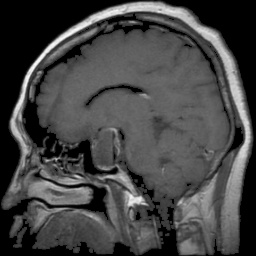

In [68]:
from PIL import Image
# img = Image.open(r"G:\BrainTumor\Dataset\test\glioma_tumor\G_9.jpg")
# img = Image.open(r"G:\BrainTumor\Dataset\test\normal\N_4.jpg")
img = Image.open(r"G:\BrainTumor\Dataset\test\pituitary_tumor\P_7.jpg")
img

In [69]:
inputdata= transform(img)
inputdata=inputdata.unsqueeze(0).to("cuda")
print(inputdata.shape)

torch.Size([1, 3, 256, 256])


In [70]:
logits=bestmodel(inputdata)
preds = torch.argmax(logits, -1)


In [71]:
classname={0:"glioma_tumor", 1:"meningioma_tumor", 2:"normal_tumor", 3:"pituitary_tumor"}


In [72]:
classname[int(preds.cpu().numpy())]

C:\Users\nguye\AppData\Local\Temp\ipykernel_18032\1276358932.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  classname[int(preds.cpu().numpy())]


'pituitary_tumor'